In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !git clone https://github.com/magicleap/SuperGluePretrainedNetwork

In [3]:
cd /content/drive/MyDrive/Idle_robotics/

/content/drive/MyDrive/Idle_robotics


In [4]:
import rasterio
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from utils import *
import torch
import pandas as pd
from SuperGluePretrainedNetwork.models.superpoint import SuperPoint
from SuperGluePretrainedNetwork.models.superglue import SuperGlue


In [5]:
# Load satellite map
sat_img, sat_transform, sat_crs = load_satellite_map("task_cv_model/map.tif")

# Load drone images
drone_imgs = load_drone_images("task_cv_model/train_data/drone_images/")

# Preprocess drone images
drone_imgs_proc = preprocess_drone_images(drone_imgs)

sat_gray = satellite_to_gray(sat_img)

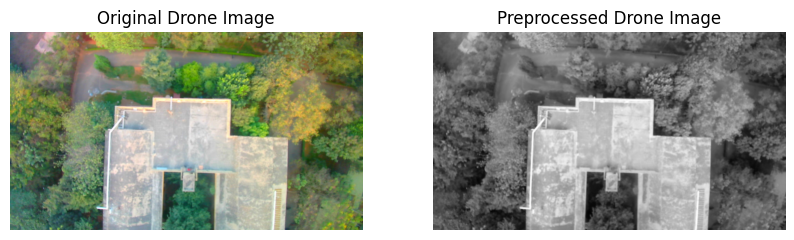

In [6]:
name = list(drone_imgs.keys())[200]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(drone_imgs[name], cv2.COLOR_BGR2RGB))
plt.title("Original Drone Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(drone_imgs_proc[name], cmap='gray')
plt.title("Preprocessed Drone Image")
plt.axis("off")

plt.show()

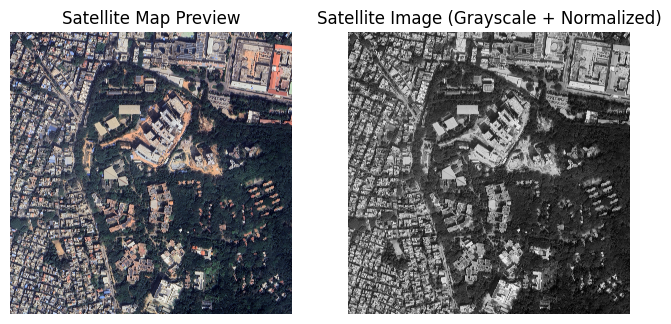

In [7]:
sat_gray = normalize_uint8(satellite_to_gray(sat_img))
plt.figure(figsize=(8, 8))
plt.subplot(121).imshow(sat_img[:, :, :3])  # use first 3 bands
plt.title("Satellite Map Preview")
plt.axis("off")
plt.subplot(122).imshow(sat_gray, cmap="gray")
plt.title("Satellite Image (Grayscale + Normalized)")
plt.axis("off")
plt.show()

In [8]:
sat_tiles = tile_image(sat_gray)
sat_features = []

for t in sat_tiles:
    kp, des = extract_sift(t["tile"])
    if des is not None:
        sat_features.append({
            "kp": kp,
            "des": des,
            "offset": t["offset"],
            "tile": t["tile"]
        })
sample_tile = sat_features[0]["tile"]

In [28]:


def match_orb(img1, img2):
    orb = cv2.ORB_create(nfeatures=3000)

    t0 = time.time()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(des1, des2, k=2)
    good = ratio_test(matches, 0.75)
    H, inliers = ransac_verify(kp1, kp2, good)
    t = time.time() - t0

    return {
        "method": "ORB",
        "keypoints": (len(kp1), len(kp2)),
        "raw_matches": len(matches),
        "good_matches": len(good),
        "inliers": inliers,
        "time": t
    }

def match_sift(img1, img2):
    sift = cv2.SIFT_create(nfeatures=4000)

    t0 = time.time()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    flann = cv2.FlannBasedMatcher(
        dict(algorithm=1, trees=5),
        dict(checks=50)
    )

    matches = flann.knnMatch(des1.astype(np.float32),
                             des2.astype(np.float32), k=2)

    good = ratio_test(matches, 0.85)
    H, inliers = ransac_verify(kp1, kp2, good)
    t = time.time() - t0

    return {
        "method": "SIFT",
        "keypoints": (len(kp1), len(kp2)),
        "raw_matches": len(matches),
        "good_matches": len(good),
        "inliers": inliers,
        "time": t
    }

def match_surf(img1, img2):
    surf = cv2.xfeatures2d.SURF_create(hessianThreshold=400)

    t0 = time.time()
    kp1, des1 = surf.detectAndCompute(img1, None)
    kp2, des2 = surf.detectAndCompute(img2, None)

    flann = cv2.FlannBasedMatcher(
        dict(algorithm=1, trees=5),
        dict(checks=50)
    )

    matches = flann.knnMatch(des1, des2, k=2)
    good = ratio_test(matches, 0.8)
    H, inliers = ransac_verify(kp1, kp2, good)
    t = time.time() - t0

    return {
        "method": "SURF",
        "keypoints": (len(kp1), len(kp2)),
        "raw_matches": len(matches),
        "good_matches": len(good),
        "inliers": inliers,
        "time": t
    }

def match_superpoint(img1, img2, sp, sg, device):
    def prep(img):
        return torch.from_numpy(img / 255.).float()[None, None].to(device)

    t0 = time.time()

    # --- SuperPoint inference ---
    out0 = sp({'image': prep(img1)})
    out1 = sp({'image': prep(img2)})

    # --- FORCE correct tensor format ---
    kpts0 = out0['keypoints']
    kpts1 = out1['keypoints']
    desc0 = out0['descriptors']
    desc1 = out1['descriptors']
    scores0 = out0['scores']
    scores1 = out1['scores']

    # Ensure tensors and batch dim
    if isinstance(kpts0, list):
        kpts0 = torch.stack(kpts0)
        desc0 = torch.stack(desc0)
        scores0 = torch.stack(scores0)

    if isinstance(kpts1, list):
        kpts1 = torch.stack(kpts1)
        desc1 = torch.stack(desc1)
        scores1 = torch.stack(scores1)

    data = {
        'keypoints0': kpts0.to(device),
        'keypoints1': kpts1.to(device),
        'descriptors0': desc0.to(device),
        'descriptors1': desc1.to(device),
        'scores0': scores0.to(device),
        'scores1': scores1.to(device),
        'image0': prep(img1),
        'image1': prep(img2),
    }

    # --- SuperGlue ---
    pred = sg(data)

    matches = pred['matches0'][0].cpu().numpy()
    # good = ratio_test(matches, 0.8)
    valid = matches > -1
    inliers = int(valid.sum())

    t = time.time() - t0

    return {
        "method": "SuperPoint+SuperGlue",
        "keypoints": (kpts0.shape[1], kpts1.shape[1]),
        "raw_matches": len(matches),
        "good_matches": inliers,
        "inliers": inliers,
        "time": t
    }


In [29]:
results = []

results.append(match_orb(drone_imgs_proc[name], sample_tile))
# results.append(match_surf(drone_imgs_proc[name], sample_tile))
results.append(match_sift(drone_imgs_proc[name], sample_tile))
# results.append(match_superpoint(drone_imgs_proc[name], sample_tile))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

sp = SuperPoint({
    'nms_radius': 4,
    'keypoint_threshold': 0.005,
    'max_keypoints': 1024
}).to(device).eval()

sg = SuperGlue({
    'weights': 'outdoor',
    'sinkhorn_iterations': 20,
    'match_threshold': 0.05,
}).to(device).eval()

results.append(match_superpoint(drone_imgs_proc[name], sample_tile, sp, sg, device))

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


In [30]:
df = pd.DataFrame(results)
print(df)

                 method     keypoints  raw_matches  good_matches  inliers  \
0                   ORB  (2536, 3000)         2536            14        5   
1                  SIFT  (1800, 3681)         1800           126        8   
2  SuperPoint+SuperGlue   (1024, 484)         1024             1        1   

       time  
0  0.320872  
1  1.124328  
2  9.695558  
